**Place frame 1 and frame 2 in the root directory.**


In [1]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.9 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/rogerhcheng/LiteFlowNet2-TF2.git

Cloning into 'LiteFlowNet2-TF2'...
remote: Enumerating objects: 39, done.
remote: Total 39 (delta 0), reused 0 (delta 0), pack-reused 39
Receiving objects: 100% (39/39), 47.19 MiB | 28.36 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [3]:
cd LiteFlowNet2-TF2/

/content/LiteFlowNet2-TF2


In [4]:
# Run inference on the test images.
# COPY IMAGES FOLDER !!! (frame1.png, frame2.png)


import math
import numpy as np
import cv2
import tensorflow.compat.v1 as tf
from PIL import Image
from model import LiteFlowNet2
import argparse

from draw_flow import *
tf.disable_eager_execution()


def flowMapToBGR(flow_map):
    # TODO: Convert flow map to magnitudes and angles
    x = flow_map[:, :, 1] # cols
    y = flow_map[:, :, 0] # rows
    magnitude, angle = cv2.cartToPolar(x, y)

    # TODO: Scale and create hsv image from angles and magnitudes.
    hsv = np.zeros((flow_map.shape[0], flow_map.shape[1], 3), dtype="uint8")
    hsv[:,:,0] = angle * 180 / np.pi / 2    # H in cv2 is between 0° and 180°
    hsv[:,:,1] = 255                        # Maximum saturation.
    hsv[:,:,2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

    # Convert from hsv to bgr and return.
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return bgr


def pad_image(image):
    if len(image.shape) == 3:
        h, w, c = image.shape
    else:
        h, w = image.shape
        c = 1

    nh = int(math.ceil(h / 32.) * 32)
    nw = int(math.ceil(w / 32.) * 32)

    pad_i = np.zeros([nh, nw, c])
    pad_i[:h, :w] = image
    return pad_i


# Reset tf session.
tf.reset_default_graph()

# Create TF session.
sess = tf.Session()
model = LiteFlowNet2(isSintel=True)
tens1 = tf.placeholder(tf.float32, shape=[None, None, None, 3])
tens2 = tf.placeholder(tf.float32, shape=[None, None, None, 3])
out = model(tens1, tens2)

# Load model.
saver = tf.train.Saver()
saver.restore(sess, "./models/LiteFlowNet2_Sintel_model")


# Load images.
inp1 = cv2.imread("./../frame1.png")
inp2 = cv2.imread("./../frame2.png")

# Prepare input.
w = inp1.shape[1]
h = inp1.shape[0]
inp1 = np.float32(np.expand_dims(pad_image(inp1), 0)) / 255.0
inp2 = np.float32(np.expand_dims(pad_image(inp2), 0)) / 255.0

# input in bgr format
flow = sess.run(out, feed_dict={tens1: inp1, tens2: inp2})[0, :h, :w, :]


# visualise flow with color model as image and save
flow_image = flowMapToBGR(flow)

# Save output file.
cv2.imwrite("out.png", flow_image)


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


True

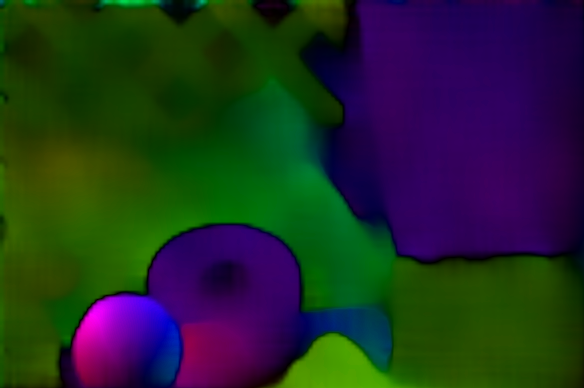

In [5]:
# Show image in google colab.
from google.colab.patches import cv2_imshow
import cv2

img = cv2.imread("out.png")
cv2_imshow(img)